# 충치 이미지 구분 프로젝트

### 사용 패키지

In [24]:
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver #동적 웹페이지 패키지
from selenium.webdriver.common.keys import Keys # 동적 웹페이지 스크롤 패키지
import time # 동적 웹페이지 시간 지연 설정 패키지
from selenium.webdriver.common.by import By #동적 웹페이지 By 클래스
import urllib.request as req # 웹페이지 사진 다운로드
from pandas import DataFrame, Series
import os #폴더 생성 패키지
from PIL import Image #사진 불러오기
import glob #전체 사진 불러오기
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, Flatten, Dense, Dropout #CNN 사진 학습
from tensorflow.keras.models import Model, Sequential,load_model #CNN 사진 학습 및 모델 저장 및 로딩
from sklearn.model_selection import train_test_split #train, test 데이터셋 분리
from tensorflow.keras.preprocessing.image import ImageDataGenerator #이미지 학습시 변형
from keras.preprocessing.image import img_to_array, load_img, array_to_img #이미지 불러오기, array로 변환
from scikeras.wrappers import KerasClassifier #gridsearchCV시 사용
from sklearn.model_selection import GridSearchCV #gridsearchCV시 사용
from tensorflow.keras.applications.vgg16 import preprocess_input # 이미지 스케일링
import numpy as np #array로 변환한 이미지 데이터 사용
import tensorflow as tf
import seaborn as sns
import matplotlib.pylab as plt
import time
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import pickle #모델 저장
import joblib #모델 저장
from sklearn.metrics import accuracy_score

### 충치사진 스크래핑을 통해 수집 (구글)

In [2]:
url1='https://www.google.com/search?q='
url2='&source=lnms&tbm=isch&sa=X'
lst = ['충치','충치 사진','유아 충치','dental caries'] #충치 한글, 영문으로 검색

In [ ]:
driver = webdriver.Chrome('c:/data_bigdata/chromedriver.exe')
for j in lst:
    pic_link=[]
    driver.get(url1+j+url2) # 충치 이미지 주소로 이동
    # 스크롤 페이지 최하단까지 내리기
    for i in range(10): # 스크롤 후 결과 더보기가 뜨면 클릭
        driver.find_element(By.TAG_NAME,'body').send_keys(Keys.END)
        time.sleep(1)
        try: 
            driver.find_element(By.CLASS_NAME,'r0zKGf').click()   
            time.sleep(1)
        except:
            try:
                driver.find_element(By.CLASS_NAME,'YstHxe').click()
                time.sleep(1)
            except:
                pass
    html = driver.page_source # 현재 페이지 소스 변수 저장
    soup = BeautifulSoup(html, 'html.parser') # 페이지 소스 beautiful soup 변수 저장
    for i in soup.select_one('div.OcgH4b').select('img'):
        try: #사진 저장(2가지attrs에 저장되어 try문 사용)
            pic_link.append(i.attrs['src'])
        except:
            try:
                pic_link.append(i.attrs['data-src'])
            except:
                pass
   
    # 사진 다운로드
    for i in range(len(pic_link)):
        path = 'c:/data_bigdata/dental_caries/pic/dental_caries/'
        if not os.path.isdir(path): #폴더가 존재하지 않는다면 폴더 생성
            os.makedirs(path)
        try:
            req.urlretrieve(pic_link[i],path+f'충치_{i}.jpg')
        except:
            pass

driver.close()

수집된 데이터를 수기로 구분하여 정제함
정제 후 파일 이름 공통되게 수정

In [ ]:
path = "c:/data_bigdata/dental_caries/pic/dental_caries/"
files = os.listdir(path)
for index, file in enumerate(files):
    os.rename(path+file, path +'dental_caries_' + str(index)+ '.jpg')

# 수집된 사진으로 모델 학습
## 1-1) CNN - input size (64*64)

In [212]:
pic_dir = 'c:/data_bigdata/dental_caries/pic_total/train/'
cate = ['caries','no_caries']

In [228]:
image_w = 64
image_h = 64

x=[]
y=[]

for idx, cate in enumerate(categories):
    label = [0 for i in range(2)]
    label[idx] = 1
    files = glob.glob(pic_dir+cate+'/*.jpg')
    for i in files:
        img = Image.open(i)
        img = img.convert('RGB').resize((image_w,image_h))
        data = np.array(img)
        x.append(data)
        y.append(label)
print('사진 개수 :',len(x))
print('정답 개수 :',len(y))
print('사진 shape :',x[0].shape)

사진 개수 : 722
정답 개수 : 722
사진 shape : (64, 64, 3)


In [229]:
x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

(722, 64, 64, 3)
(722, 2)


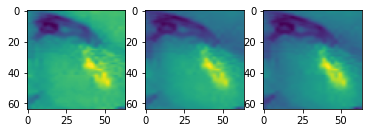

In [230]:
plt.subplot(1,3,1)
plt.imshow(x[1][:,:,0])
plt.subplot(1,3,2)
plt.imshow(x[1][:,:,1])
plt.subplot(1,3,3)
plt.imshow(x[1][:,:,2]);

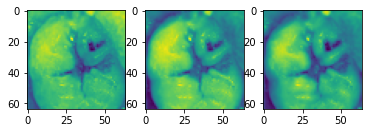

In [231]:
plt.subplot(1,3,1)
plt.imshow(x[50][:,:,0])
plt.subplot(1,3,2)
plt.imshow(x[50][:,:,1])
plt.subplot(1,3,3)
plt.imshow(x[50][:,:,2]);

In [232]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [233]:
xy = (x_train,x_test,y_train,y_test)
np.save('c:/data_bigdata/dental_caries/cnn_dental_caries64.npy',xy) #파일로 저장 array와 정답으로

In [234]:
print(x_train.shape)
print(x_test.shape)

(577, 64, 64, 3)
(145, 64, 64, 3)


#### 이미지 스케일 작업 후 모델 적용

In [235]:
np.max(x_train)

255

In [236]:
x_train = x_train.astype('float')/255
x_test = x_test.astype('float')/255

In [237]:
model_cnn64 = Sequential()
model_cnn64.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',input_shape=(64,64,3),activation='relu'))
model_cnn64.add(MaxPool2D(pool_size=(2,2)))

model_cnn64.add(Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model_cnn64.add(MaxPool2D(pool_size=(2,2)))

model_cnn64.add(Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model_cnn64.add(MaxPool2D(pool_size=(2,2)))

model_cnn64.add(Flatten())
model_cnn64.add(Dense(512,activation='relu'))
model_cnn64.add(Dropout(0.5))

model_cnn64.add(Dense(2,activation='softmax'))
model_cnn64.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 8, 8, 64)       

In [238]:
model_cnn64.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history_cnn64 = model_cnn64.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=32)

Epoch 1/20
19/19 [==============================] - 4s 171ms/step - loss: 0.7287 - accuracy: 0.5321 - val_loss: 0.6829 - val_accuracy: 0.5655
Epoch 2/20
19/19 [==============================] - 3s 142ms/step - loss: 0.6724 - accuracy: 0.6118 - val_loss: 0.6469 - val_accuracy: 0.6000
Epoch 3/20
19/19 [==============================] - 3s 143ms/step - loss: 0.5321 - accuracy: 0.7279 - val_loss: 0.4888 - val_accuracy: 0.7862
Epoch 4/20
19/19 [==============================] - 3s 149ms/step - loss: 0.4602 - accuracy: 0.8024 - val_loss: 0.6212 - val_accuracy: 0.7310
Epoch 5/20
19/19 [==============================] - 3s 152ms/step - loss: 0.4956 - accuracy: 0.7868 - val_loss: 0.4080 - val_accuracy: 0.8138
Epoch 6/20
19/19 [==============================] - 3s 152ms/step - loss: 0.3898 - accuracy: 0.8475 - val_loss: 0.3779 - val_accuracy: 0.8345
Epoch 7/20
19/19 [==============================] - 3s 148ms/step - loss: 0.3180 - accuracy: 0.8735 - val_loss: 0.4460 - val_accuracy: 0.8276
Epoch 

In [239]:
max_train_accuracy64 = history_cnn64.history['accuracy'][np.argmax(history_cnn64.history['accuracy'])]
max_test_accuracy64 = history_cnn64.history['val_accuracy'][np.argmax(history_cnn64.history['val_accuracy'])]
min_train_loss64 =history_cnn64.history['loss'][np.argmin(history_cnn64.history['loss'])]
min_test_loss64 = history_cnn64.history['val_loss'][np.argmin(history_cnn64.history['val_loss'])]

print('Train Accuracy 최대값:',max_train_accuracy64)
print('Test Accuracy 최대값:',max_test_accuracy64)
print('Train loss 최소값:',min_train_loss64)
print('Test loss 최소값:',min_test_loss64)

Train Accuracy 최대값: 0.9705372452735901
Test Accuracy 최대값: 0.8896551728248596
Train loss 최소값: 0.09756918996572495
Test loss 최소값: 0.3050914406776428


In [240]:
df_history_cnn64 = DataFrame(history_cnn64.history)

In [241]:
df_history_cnn64.head()

,loss,accuracy,val_loss,val_accuracy
0,0.728711,0.532062,0.682926,0.565517
1,0.672351,0.611785,0.646903,0.600000
2,0.532053,0.727903,0.488785,0.786207
3,0.460245,0.802426,0.621243,0.731034
4,0.495595,0.786828,0.407950,0.813793


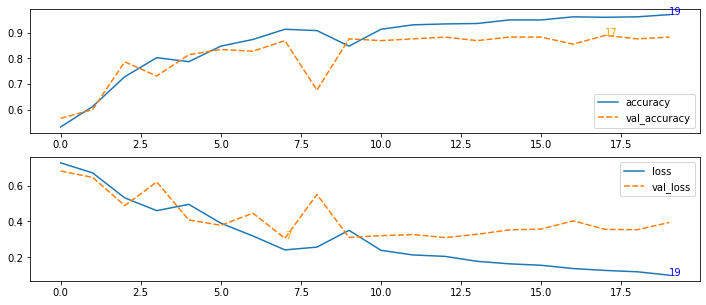

In [242]:
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
sns.lineplot(data=df_history_cnn64[['accuracy','val_accuracy']])
plt.legend(loc='lower right')
plt.text(np.argmax(df_history_cnn64['accuracy']),max_train_accuracy64,np.argmax(df_history_cnn64['accuracy']),color='blue');
plt.text(np.argmax(df_history_cnn64['val_accuracy']),max_test_accuracy64,np.argmax(df_history_cnn64['val_accuracy']),color='orange');
plt.subplot(2,1,2)
sns.lineplot(data=df_history_cnn64[['loss','val_loss']])
plt.text(np.argmin(df_history_cnn64['loss']),min_train_loss64,np.argmin(df_history_cnn64['loss']),color='blue');
plt.text(np.argmin(df_history_cnn64['val_loss']),min_test_loss64,np.argmin(df_history_cnn64['val_loss']),color='orange');
plt.show()

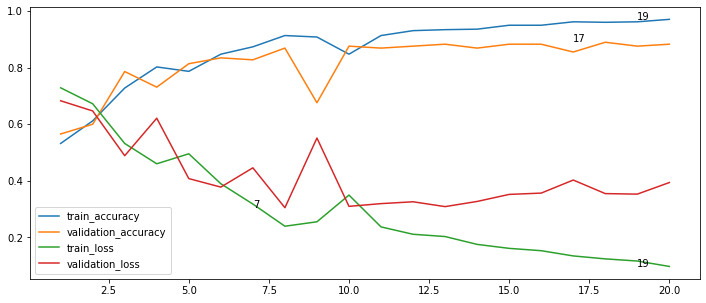

In [243]:
plt.figure(figsize=(12,5))
sns.lineplot(data=history_cnn64.history,x=range(1,21,1),y=history_cnn64.history['accuracy'],label='train_accuracy');
sns.lineplot(data=history_cnn64.history,x=range(1,21,1),y=history_cnn64.history['val_accuracy'],label='validation_accuracy');
sns.lineplot(data=history_cnn64.history,x=range(1,21,1),y=history_cnn64.history['loss'],label='train_loss');
sns.lineplot(data=history_cnn64.history,x=range(1,21,1),y=history_cnn64.history['val_loss'],label='validation_loss');

plt.text(np.argmax(history_cnn64.history['accuracy']),max_train_accuracy64,np.argmax(history_cnn64.history['accuracy']))
plt.text(np.argmax(history_cnn64.history['val_accuracy']),max_test_accuracy64,np.argmax(history_cnn64.history['val_accuracy']))
plt.text(np.argmin(history_cnn64.history['loss']),min_train_loss64,np.argmin(history_cnn64.history['loss']))
plt.text(np.argmin(history_cnn64.history['val_loss']),min_test_loss64,np.argmin(history_cnn64.history['val_loss']))
plt.show()

In [244]:
#모델 저장
model_cnn64.save('c:/data_bigdata/dental_caries/model_cnn64.h5')

with open('c:/data_bigdata/dental_caries/history_cnn64.pkl','wb') as file:
    pickle.dump(history_cnn64,file)

## 1-2) CNN - input size (128*128)

In [245]:
image_w = 128
image_h = 128

x=[]
y=[]

for idx, cate in enumerate(categories):
    label = [0 for i in range(2)]
    label[idx] = 1
    files = glob.glob(pic_dir+cate+'/*.jpg')
    for i in files:
        img = Image.open(i)
        img = img.convert('RGB').resize((image_w,image_h))
        data = np.array(img)
        x.append(data)
        y.append(label)
print('사진 개수 :',len(x))
print('정답 개수 :',len(y))
print('사진 shape :',x[0].shape)

사진 개수 : 722
정답 개수 : 722
사진 shape : (128, 128, 3)


In [246]:
x = np.array(x)
y = np.array(y)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [251]:
xy = (x_train,x_test,y_train,y_test)
np.save('c:/data_bigdata/dental_caries/cnn_dental_caries_xy128.npy',xy)

In [247]:
x_train = x_train.astype('float')/255
x_test = x_test.astype('float')/255

In [248]:
model_cnn128 = Sequential()
model_cnn128.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',input_shape=(128,128,3),activation='relu'))
model_cnn128.add(MaxPool2D(pool_size=(2,2)))

model_cnn128.add(Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model_cnn128.add(MaxPool2D(pool_size=(2,2)))

model_cnn128.add(Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model_cnn128.add(MaxPool2D(pool_size=(2,2)))

model_cnn128.add(Flatten())
model_cnn128.add(Dense(512,activation='relu'))
model_cnn128.add(Dropout(0.5))

model_cnn128.add(Dense(2,activation='softmax'))
model_cnn128.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 16, 16, 64)     

In [250]:
model_cnn128.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history_cnn128 = model_cnn128.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=32)

Epoch 1/20
19/19 [==============================] - 11s 568ms/step - loss: 0.6609 - accuracy: 0.5858 - val_loss: 0.4968 - val_accuracy: 0.7517
Epoch 2/20
19/19 [==============================] - 10s 546ms/step - loss: 0.5554 - accuracy: 0.7279 - val_loss: 0.4397 - val_accuracy: 0.8414
Epoch 3/20
19/19 [==============================] - 10s 551ms/step - loss: 0.4647 - accuracy: 0.7834 - val_loss: 0.3353 - val_accuracy: 0.8345
Epoch 4/20
19/19 [==============================] - 10s 553ms/step - loss: 0.4800 - accuracy: 0.7799 - val_loss: 0.3509 - val_accuracy: 0.8690
Epoch 5/20
19/19 [==============================] - 10s 519ms/step - loss: 0.4367 - accuracy: 0.8059 - val_loss: 0.3185 - val_accuracy: 0.8621
Epoch 6/20
19/19 [==============================] - 10s 512ms/step - loss: 0.3525 - accuracy: 0.8596 - val_loss: 0.2428 - val_accuracy: 0.9103
Epoch 7/20
19/19 [==============================] - 9s 499ms/step - loss: 0.4432 - accuracy: 0.8440 - val_loss: 0.3431 - val_accuracy: 0.8759


In [29]:
max_train_accuracy128 = history_cnn128.history['accuracy'][np.argmax(history_cnn128.history['accuracy'])]
max_test_accuracy128 = history_cnn128.history['val_accuracy'][np.argmax(history_cnn128.history['val_accuracy'])]
min_train_loss128 =history_cnn128.history['loss'][np.argmin(history_cnn128.history['loss'])]
min_test_loss128 = history_cnn128.history['val_loss'][np.argmin(history_cnn128.history['val_loss'])]

print('Train Accuracy 최대값:',max_train_accuracy128)
print('Test Accuracy 최대값:',max_test_accuracy128)
print('Train loss 최소값:',min_train_loss128)
print('Test loss 최소값:',min_test_loss128)

Train Accuracy 최대값: 0.9636048674583435
Test Accuracy 최대값: 0.9448275566101074
Train loss 최소값: 0.10399208217859268
Test loss 최소값: 0.17263400554656982


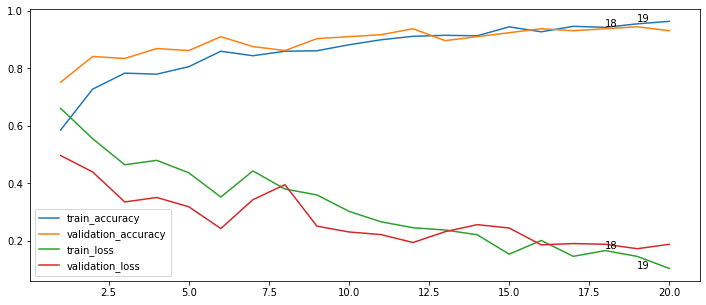

In [253]:
plt.figure(figsize=(12,5))
sns.lineplot(data=history_cnn128.history,x=range(1,21,1),y=history_cnn128.history['accuracy'],label='train_accuracy');
sns.lineplot(data=history_cnn128.history,x=range(1,21,1),y=history_cnn128.history['val_accuracy'],label='validation_accuracy');
sns.lineplot(data=history_cnn128.history,x=range(1,21,1),y=history_cnn128.history['loss'],label='train_loss');
sns.lineplot(data=history_cnn128.history,x=range(1,21,1),y=history_cnn128.history['val_loss'],label='validation_loss');

plt.text(np.argmax(history_cnn128.history['accuracy']),max_train_accuracy128,np.argmax(history_cnn128.history['accuracy']))
plt.text(np.argmax(history_cnn128.history['val_accuracy']),max_test_accuracy128,np.argmax(history_cnn128.history['val_accuracy']))
plt.text(np.argmin(history_cnn128.history['loss']),min_train_loss128,np.argmin(history_cnn128.history['loss']))
plt.text(np.argmin(history_cnn128.history['val_loss']),min_test_loss128,np.argmin(history_cnn128.history['val_loss']))
plt.show()

In [262]:
#모델 저장
model_cnn128.save('c:/data_bigdata/dental_caries/model_cnn128.h5')

with open('c:/data_bigdata/dental_caries/history_cnn128.pkl','wb') as file:
    pickle.dump(history_cnn128,file)

## 1-3) CNN - input size(224 * 224)

In [254]:
image_w = 224
image_h = 224

x=[]
y=[]

for idx, cate in enumerate(categories):
    label = [0 for i in range(2)]
    label[idx] = 1
    files = glob.glob(pic_dir+cate+'/*.jpg')
    for i in files:
        img = Image.open(i)
        img = img.convert('RGB').resize((image_w,image_h))
        data = np.array(img)
        x.append(data)
        y.append(label)
print('사진 개수 :',len(x))
print('정답 개수 :',len(y))
print('사진 shape :',x[0].shape)

사진 개수 : 722
정답 개수 : 722
사진 shape : (224, 224, 3)


In [255]:
x = np.array(x)
y = np.array(y)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
xy = (x_train,x_test,y_train,y_test)
np.save('c:/data_bigdata/dental_caries/cnn_dental_caries_xy224.npy',xy)

In [256]:
x_train = x_train.astype('float')/255
x_test = x_test.astype('float')/255

In [257]:
model_cnn224 = Sequential()
model_cnn224.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',input_shape=(224,224,3),activation='relu'))
model_cnn224.add(MaxPool2D(pool_size=(2,2)))

model_cnn224.add(Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model_cnn224.add(MaxPool2D(pool_size=(2,2)))

model_cnn224.add(Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model_cnn224.add(MaxPool2D(pool_size=(2,2)))

model_cnn224.add(Flatten())
model_cnn224.add(Dense(512,activation='relu'))
model_cnn224.add(Dropout(0.5))

model_cnn224.add(Dense(2,activation='softmax'))
model_cnn224.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 28, 28, 64)     

In [258]:
model_cnn224.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history_cnn224 = model_cnn224.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=32)

Epoch 1/20
19/19 [==============================] - 33s 2s/step - loss: 2.0334 - accuracy: 0.5442 - val_loss: 0.6909 - val_accuracy: 0.4207
Epoch 2/20
19/19 [==============================] - 31s 2s/step - loss: 0.6904 - accuracy: 0.5234 - val_loss: 0.6680 - val_accuracy: 0.7517
Epoch 3/20
19/19 [==============================] - 30s 2s/step - loss: 0.6521 - accuracy: 0.6326 - val_loss: 0.6088 - val_accuracy: 0.7724
Epoch 4/20
19/19 [==============================] - 31s 2s/step - loss: 0.6022 - accuracy: 0.7348 - val_loss: 0.5750 - val_accuracy: 0.7379
Epoch 5/20
19/19 [==============================] - 32s 2s/step - loss: 0.5881 - accuracy: 0.7470 - val_loss: 0.5408 - val_accuracy: 0.7724
Epoch 6/20
19/19 [==============================] - 30s 2s/step - loss: 0.5881 - accuracy: 0.7452 - val_loss: 0.5250 - val_accuracy: 0.8069
Epoch 7/20
19/19 [==============================] - 30s 2s/step - loss: 0.4747 - accuracy: 0.7955 - val_loss: 0.4855 - val_accuracy: 0.7793
Epoch 8/20
19/19 [==

In [259]:
max_train_accuracy224 = history_cnn224.history['accuracy'][np.argmax(history_cnn224.history['accuracy'])]
max_test_accuracy224 = history_cnn224.history['val_accuracy'][np.argmax(history_cnn224.history['val_accuracy'])]
min_train_loss224 =history_cnn224.history['loss'][np.argmin(history_cnn224.history['loss'])]
min_test_loss224 = history_cnn224.history['val_loss'][np.argmin(history_cnn224.history['val_loss'])]

print('Train Accuracy 최대값:',max_train_accuracy224)
print('Test Accuracy 최대값:',max_test_accuracy224)
print('Train loss 최소값:',min_train_loss224)
print('Test loss 최소값:',min_test_loss224)

Train Accuracy 최대값: 0.8908145427703857
Test Accuracy 최대값: 0.8551723957061768
Train loss 최소값: 0.28556686639785767
Test loss 최소값: 0.3522111177444458


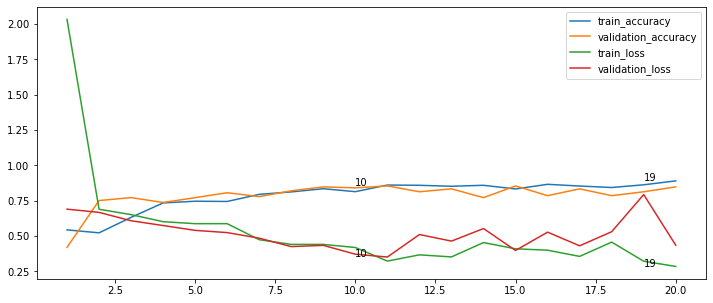

In [260]:
plt.figure(figsize=(12,5))
sns.lineplot(data=history_cnn224.history,x=range(1,21,1),y=history_cnn224.history['accuracy'],label='train_accuracy');
sns.lineplot(data=history_cnn224.history,x=range(1,21,1),y=history_cnn224.history['val_accuracy'],label='validation_accuracy');
sns.lineplot(data=history_cnn224.history,x=range(1,21,1),y=history_cnn224.history['loss'],label='train_loss');
sns.lineplot(data=history_cnn224.history,x=range(1,21,1),y=history_cnn224.history['val_loss'],label='validation_loss');

plt.text(np.argmax(history_cnn224.history['accuracy']),max_train_accuracy224,np.argmax(history_cnn224.history['accuracy']))
plt.text(np.argmax(history_cnn224.history['val_accuracy']),max_test_accuracy224,np.argmax(history_cnn224.history['val_accuracy']))
plt.text(np.argmin(history_cnn224.history['loss']),min_train_loss224,np.argmin(history_cnn224.history['loss']))
plt.text(np.argmin(history_cnn224.history['val_loss']),min_test_loss224,np.argmin(history_cnn224.history['val_loss']))
plt.show()

In [261]:
#모델 저장
model_cnn224.save('c:/data_bigdata/dental_caries/model_cnn224.h5')

In [267]:
with open('c:/data_bigdata/dental_caries/history_cnn224.pkl','wb') as file:
    pickle.dump(history_cnn224,file)


INFO:tensorflow:Assets written to: C:\Users\Hankm\AppData\Local\Temp\tmp55t4hlic\assets


## input size별 accuracy 비교

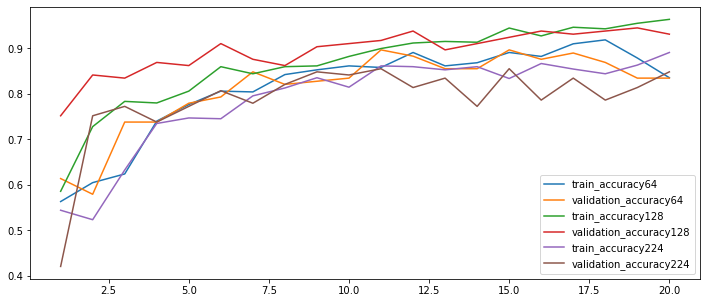

In [268]:
plt.figure(figsize=(12,5))
sns.lineplot(data=history_cnn.history,x=range(1,21,1),y=history_cnn.history['accuracy'],label='train_accuracy64');
sns.lineplot(data=history_cnn.history,x=range(1,21,1),y=history_cnn.history['val_accuracy'],label='validation_accuracy64');
sns.lineplot(data=history_cnn128.history,x=range(1,21,1),y=history_cnn128.history['accuracy'],label='train_accuracy128');
sns.lineplot(data=history_cnn128.history,x=range(1,21,1),y=history_cnn128.history['val_accuracy'],label='validation_accuracy128');
sns.lineplot(data=history_cnn224.history,x=range(1,21,1),y=history_cnn224.history['accuracy'],label='train_accuracy224');
sns.lineplot(data=history_cnn224.history,x=range(1,21,1),y=history_cnn224.history['val_accuracy'],label='validation_accuracy224');

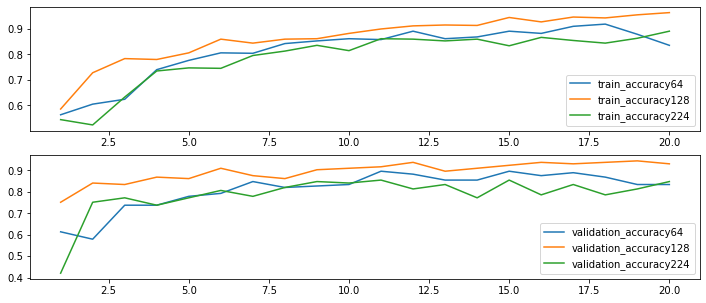

In [269]:
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
sns.lineplot(data=history_cnn.history,x=range(1,21,1),y=history_cnn.history['accuracy'],label='train_accuracy64');
sns.lineplot(data=history_cnn128.history,x=range(1,21,1),y=history_cnn128.history['accuracy'],label='train_accuracy128');
sns.lineplot(data=history_cnn224.history,x=range(1,21,1),y=history_cnn224.history['accuracy'],label='train_accuracy224');
plt.legend(loc='lower right')
plt.subplot(2,1,2)
sns.lineplot(data=history_cnn.history,x=range(1,21,1),y=history_cnn.history['val_accuracy'],label='validation_accuracy64');
sns.lineplot(data=history_cnn128.history,x=range(1,21,1),y=history_cnn128.history['val_accuracy'],label='validation_accuracy128');
sns.lineplot(data=history_cnn224.history,x=range(1,21,1),y=history_cnn224.history['val_accuracy'],label='validation_accuracy224');

정확도가 제일 높으므로 input size는 128 * 128 로 결정

## GridSearchCV를 통한 최적의 모델 확인
##### batch size, epochs, dropout rate 확인

In [2]:
x_train,x_test,y_train,y_test =np.load('c:/data_bigdata/dental_caries/cnn_dental_caries_xy128.npy',allow_pickle=True)
x_train = x_train.astype('float')/255
x_test = x_test.astype('float')/255

In [3]:
def build_model(dropout_rate=0.0):
    model = Sequential()
    model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',input_shape=(128,128,3),activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(512,activation='relu'))

    model.add(Dropout(dropout_rate)) 

    model.add(Dense(2,activation='softmax'))
    model.compile( 
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )    
    return model

In [4]:
# girdsearch에 사용할 parameters 설정
param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'dropout_rate': [0.0, 0.30, 0.50, 0.70]
}

In [5]:
# 모델 생성
kera_model = KerasClassifier(build_fn=build_model, verbose=1,dropout_rate=0.0)

In [6]:
start = time.time()
grid = GridSearchCV(estimator=kera_model, param_grid=param_grid, n_jobs=-1, cv=5, error_score='raise')
grid_result = grid.fit(x_train, y_train)
print('grid search 소요시간 : {:.0f}초'.format(time.time()-start))

KeyboardInterrupt: 

In [16]:
print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))

Best: 0.847510 using {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 20}


In [321]:
#모델 저장
joblib.dump(grid, 'c:/data_bigdata/dental_caries/grid_model.pkl')
joblib.dump(grid.best_estimator_,'c:/data_bigdata/dental_caries/grid_best_estimator.pkl')
with open('c:/data_bigdata/dental_caries/grid_result.pkl','wb') as file:
    pickle.dump(grid_result,file)

INFO:tensorflow:Assets written to: C:\Users\Hankm\AppData\Local\Temp\tmpotf0dxza\assets
INFO:tensorflow:Assets written to: C:\Users\Hankm\AppData\Local\Temp\tmp7fj6nzo9\assets
INFO:tensorflow:Assets written to: C:\Users\Hankm\AppData\Local\Temp\tmp_os6d69v\assets


In [7]:
loaded_model=joblib.load('c:/data_bigdata/dental_caries/grid_best_estimator.pkl')

In [14]:
grid_result=joblib.load('c:/data_bigdata/dental_caries/grid_result.pkl')

In [10]:
predict = loaded_model.predict(x_test)

10/10 [==============================] - 1s 72ms/step


In [13]:
accuracy_score(y_test,predict)

0.3586206896551724

정확도가 0.847510이 나왔었으나 test dataset은 정확도가 낮음

## GridSearchCV에서 확인된 최적의 Parameter 적용 후 accuracy 1-2의 모델과 비교

In [17]:
x_train,x_test,y_train,y_test =np.load('c:/data_bigdata/dental_caries/cnn_dental_caries_xy128.npy',allow_pickle=True)
x_train = x_train.astype('float')/255
x_test = x_test.astype('float')/255

In [18]:
es_cb = EarlyStopping(monitor='val_accuracy',mode='max',patience=1,verbose=1)

In [19]:
model_grid_best = Sequential()
model_grid_best.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',input_shape=(128,128,3),activation='relu'))
model_grid_best.add(MaxPool2D(pool_size=(2,2)))

model_grid_best.add(Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model_grid_best.add(MaxPool2D(pool_size=(2,2)))

model_grid_best.add(Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model_grid_best.add(MaxPool2D(pool_size=(2,2)))

model_grid_best.add(Flatten())
model_grid_best.add(Dense(512,activation='relu'))
model_grid_best.add(Dropout(0.3))

model_grid_best.add(Dense(2,activation='softmax'))
model_grid_best.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history_grid_best = model_grid_best.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=16,callbacks=[es_cb])

Epoch 1/20
37/37 [==============================] - 15s 379ms/step - loss: 0.6874 - accuracy: 0.5754 - val_loss: 0.6710 - val_accuracy: 0.6414
Epoch 2/20
37/37 [==============================] - 14s 366ms/step - loss: 0.6884 - accuracy: 0.5754 - val_loss: 0.6649 - val_accuracy: 0.6414
Epoch 2: early stopping


accuracy가 향상되지 않아 early stopping 실행됨.

## 2) Data Augmentation 이용

In [30]:
train_path = 'c:/data_bigdata/dental_caries/pic_total/train'
vali_path = 'c:/data_bigdata/dental_caries/pic_total/validation'

In [31]:
len(os.listdir('c:/data_bigdata/dental_caries/pic_total/train/caries'))

300

In [32]:
training_datagen = ImageDataGenerator(
preprocessing_function=preprocess_input,
rotation_range=10,
width_shift_range=0.5,
height_shift_range=0.1,
shear_range=0.1,
zoom_range=0.3,
horizontal_flip=True,
fill_mode='nearest'
)

training_generator = training_datagen.flow_from_directory(train_path,
batch_size=32,
target_size=(128,128),
class_mode='categorical')

training_generator.class_indices

Found 726 images belonging to 2 classes.


{'caries': 0, 'no_caries': 1}

In [33]:
validation_generator = training_datagen.flow_from_directory(vali_path,
batch_size=32,
shuffle=True,
target_size=(128,128),
class_mode='categorical')
validation_generator.class_indices

Found 33 images belonging to 2 classes.


{'caries': 0, 'no_caries': 1}

In [34]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',input_shape=(128,128,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)      

In [35]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(training_generator,validation_data=validation_generator,epochs=20)

Epoch 1/20
23/23 [==============================] - 23s 935ms/step - loss: 2.6511 - accuracy: 0.5331 - val_loss: 0.7267 - val_accuracy: 0.4848
Epoch 2/20
23/23 [==============================] - 17s 711ms/step - loss: 0.6464 - accuracy: 0.6391 - val_loss: 0.7233 - val_accuracy: 0.5758
Epoch 3/20
23/23 [==============================] - 16s 708ms/step - loss: 0.6380 - accuracy: 0.6846 - val_loss: 0.6128 - val_accuracy: 0.6667
Epoch 4/20
23/23 [==============================] - 17s 718ms/step - loss: 0.5158 - accuracy: 0.7672 - val_loss: 0.5965 - val_accuracy: 0.7273
Epoch 5/20
23/23 [==============================] - 17s 717ms/step - loss: 0.4588 - accuracy: 0.7989 - val_loss: 0.5156 - val_accuracy: 0.6970
Epoch 6/20
23/23 [==============================] - 17s 711ms/step - loss: 0.4267 - accuracy: 0.8278 - val_loss: 0.7366 - val_accuracy: 0.6667
Epoch 7/20
23/23 [==============================] - 17s 718ms/step - loss: 0.3965 - accuracy: 0.8388 - val_loss: 0.2929 - val_accuracy: 0.8182

In [36]:
history.history['accuracy'][tf.argmax(history.history['accuracy'])]

0.8801652789115906

In [37]:
history.history['val_accuracy'][tf.argmax(history.history['val_accuracy'])]

0.8787878751754761

In [44]:
max_train_accuracy = history.history['accuracy'][np.argmax(history.history['accuracy'])]
max_test_accuracy = history.history['val_accuracy'][np.argmax(history.history['val_accuracy'])]
min_train_loss =history.history['loss'][np.argmin(history.history['loss'])]
min_test_loss = history.history['val_loss'][np.argmin(history.history['val_loss'])]

print('Train Accuracy 최대값:',max_train_accuracy)
print('Test Accuracy 최대값:',max_test_accuracy)
print('Train loss 최소값:',min_train_loss)
print('Test loss 최소값:',min_test_loss)

Train Accuracy 최대값: 0.8801652789115906
Test Accuracy 최대값: 0.8787878751754761
Train loss 최소값: 0.3128146827220917
Test loss 최소값: 0.2929314076900482


In [39]:
df_history = DataFrame(history.history)

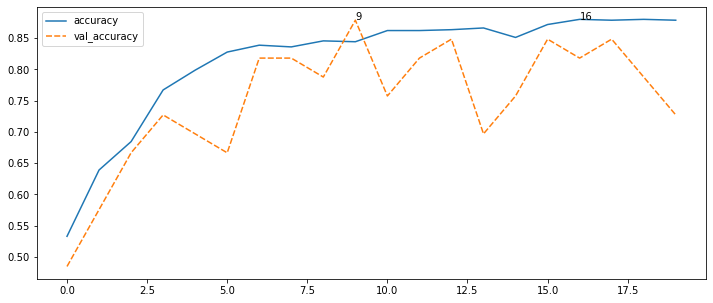

In [40]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df_history[['accuracy','val_accuracy']]);
plt.text(np.argmax(df_history['accuracy']),np.max(df_history['accuracy']),np.argmax(df_history['accuracy']));
plt.text(np.argmax(df_history['val_accuracy']),np.max(df_history['val_accuracy']),np.argmax(df_history['val_accuracy']));

In [42]:
model.save('c:/data_bigdata/dental_caries/Augmentation_model.h5')
joblib.dump(history,'c:/data_bigdata/dental_caries/Augmentation_history.pkl')

INFO:tensorflow:Assets written to: C:\Users\Hankm\AppData\Local\Temp\tmp5qs6_rfo\assets


['c:/data_bigdata/dental_caries/Augmentation_history.pkl']

## 1-2) 와 2) 모델 비교

In [26]:
model_cnn128 = load_model('c:/data_bigdata/dental_caries/model_cnn128.h5')
history_cnn128 = joblib.load('c:/data_bigdata/dental_caries/history_cnn128.pkl')

In [28]:
df_history_cnn128 = DataFrame(history_cnn128.history)

1-2) model Train Accuracy 최대값:0.964
1-2) model Test Accuracy 최대값:0.945
2) model Train Accuracy 최대값:0.880
2) model Test Accuracy 최대값:0.879


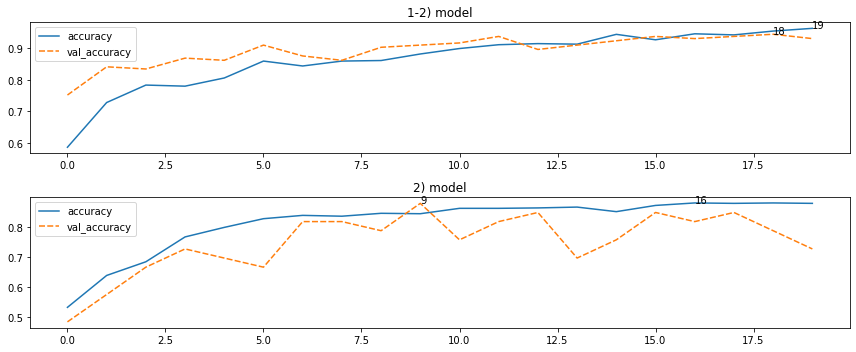

In [51]:
plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
sns.lineplot(data=df_history_cnn128[['accuracy','val_accuracy']]);
plt.text(np.argmax(history_cnn128.history['accuracy']),max_train_accuracy128,np.argmax(history_cnn128.history['accuracy']))
plt.text(np.argmax(history_cnn128.history['val_accuracy']),max_test_accuracy128,np.argmax(history_cnn128.history['val_accuracy']))
plt.title('1-2) model')
plt.subplot(2,1,2)
sns.lineplot(data=df_history[['accuracy','val_accuracy']]);
plt.text(np.argmax(history.history['accuracy']),max_train_accuracy,np.argmax(history.history['accuracy']))
plt.text(np.argmax(history.history['val_accuracy']),max_test_accuracy,np.argmax(history.history['val_accuracy']))
plt.title('2) model')
plt.tight_layout();
print('1-2) model Train Accuracy 최대값:{:.3f}'.format(max_train_accuracy128))
print('1-2) model Test Accuracy 최대값:{:.3f}'.format(max_test_accuracy128))
print('2) model Train Accuracy 최대값:{:.3f}'.format(max_train_accuracy))
print('2) model Test Accuracy 최대값:{:.3f}'.format(max_test_accuracy))


## 최종으로 1-2) input size 128 * 128의 모델 선택